In [1]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split

from sklearn.metrics import (
    accuracy_score, auc,
    confusion_matrix,
    PrecisionRecallDisplay,
    roc_auc_score, roc_curve,
    RocCurveDisplay,
)

# Исходный код модели

In [2]:
training_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]
header = ["color", "diameter", "label"]

Находит уникальные значения для столбца в наборе данных.

In [3]:
def unique_vals(rows, col):
    """Find the unique values for a column in a dataset."""
    return set([row[col] for row in rows])

Подсчитывает число экземпляров каждого типа в наборе данных.

In [4]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [5]:
class_counts(training_data)

{'Apple': 2, 'Grape': 2, 'Lemon': 1}

Проверяет, является ли значение числовым.

In [6]:
def is_numeric(value):
    """Test if a value is numeric."""
    return isinstance(value, int) or isinstance(value, float)

Вопрос, который используется для разделения набора данных.

Этот класс просто записывает «номер столбца» (например, 0 для цвета) и  
"значение столбца" (например, зеленый). Метод `match` используется для сравнения  
значения признака в примере со значением признака, хранящегося в вопросе.

In [7]:
class Question:
    """A Question is used to partition a dataset.

    This class just records a 'column number' (e.g., 0 for Color) and a
    'column value' (e.g., Green). The 'match' method is used to compare
    the feature value in an example to the feature value stored in the
    question. See the demo below.
    """

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            header[self.column], condition, str(self.value))

In [8]:
Question(0, 'Male')

Is color == Male?

Разбивает набор данных.

Для каждой строки в наборе данных проверяет, соответствует ли она вопросу. Если  
соответствует, то добавляет строку в «true_rows», в противном случае добавляет в «false_rows».

In [9]:
def partition(rows, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
            
    return true_rows, false_rows

In [10]:
partition(training_data, Question(0, 'Yellow'))

([['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']],
 [['Green', 3, 'Apple'], ['Red', 1, 'Grape'], ['Red', 1, 'Grape']])

In [11]:
partition(training_data, Question(0, 'Red'))

([['Red', 1, 'Grape'], ['Red', 1, 'Grape']],
 [['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']])

Рассчитывает Gini impurity для списка строк.

Gini impurity – это мера того, как часто случайно выбранный элемент из набора будет неправильно помечен, если он был помечен случайным образом в соответствии с распределением ярлыков в подмножестве.

Он достигает своего минимума (нуля), когда все наблюдения в узле попадают в одну целевую категорию.

Gini impurity - это всего лишь разновидность обычной меры энтропии для деревьев решений.

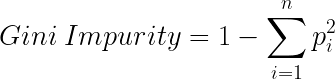

In [12]:
def gini(rows):
    """Calculate the Gini Impurity for a list of rows.

    There are a few different ways to do this, I thought this one was
    the most concise. See:
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [13]:
for label in class_counts(training_data):
    print(label)

Apple
Grape
Lemon


In [14]:
1 - (2/5)**2 - (2/5)**2 - (1/5)**2

0.6399999999999999

In [15]:
gini(training_data)

0.6399999999999999

Information Gain – неопределенность начального узла за вычетом взвешенного impurity двух дочерних узлов.

Как правило слева это false_rows, справа это true_rows.

p --> это произведение мат. ожидание вытащить элемент и ошибки категоризации этого элемента.

In [16]:
def info_gain(left, right, current_uncertainty):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    # prob: отношение количества элементов слева к общему числу
    # 1 - prob: отношение количества элементов справа к общему числу
    p = float(len(left)) / (len(left) + len(right))  
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [17]:
left, right = partition(training_data, Question(0, 'Red'))
curr = gini(training_data)

info_gain(left, right, curr)

0.37333333333333324

Находит лучший вопрос, перебирая каждый признак и значение и вычисляя Information Gain.

In [18]:
def find_best_split(rows):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep track of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature

        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each unique value

            question = Question(col, val)  # ask what if we partition COL by VAL and OTHERS

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:  # happens only when 1 unique value left?
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)  # for each of two new branches

            # You actually can use '>' instead of '>=' here
            # but I wanted the tree to look a certain way for our
            # toy dataset.
            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

Узел Leaf классифицирует данные.

Leaf содержит словарь класса (например, «Apple») и то количество раз  
сколько он появляется в обучающем наборе данных, дошедшем до этого листа.

In [19]:
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows):
        self.predictions = class_counts(rows)

Узел принятия решения, задающий вопрос. Это ссылка на сам вопрос и на два дочерних узла.

In [20]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

Строит дерево.

In [21]:
def build_tree(rows):
    """Builds the tree.

    Rules of recursion: 1) Believe that it works. 2) Start by checking
    for the base case (no further information gain). 3) Prepare for
    giant stack traces.
    """

    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0:
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # depending on the answer.
    return Decision_Node(question, true_branch, false_branch)

Выводит дерево.

In [22]:
def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

Классифицирует.

In [23]:
def classify(row, node):
    """See the 'rules of recursion' above."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

Выводит предсказания в листе.

In [24]:
def print_leaf(counts):
    """A nicer way to print the predictions at a leaf."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

# Задание

### Применить написанное дерево к train датасету Титаник.

https://www.kaggle.com/c/titanic.
 
На первом этапе взять признаки и разметку 'Sex', 'Age', 'Survived'.

```python
header = ['Sex', 'Age', 'Survived']
```

In [25]:
def predict_proba(rows: np.array, estimator: Decision_Node) -> np.array:
    """Returns the probabilities of the classes. Works with binary classification only.
    """
    probabilities = []

    if type(rows) == pd.DataFrame:
        rows = rows.values

    # For each row
    for row in rows:
        # Get classification
        class_dict = classify(row, estimator).copy()
        keys = class_dict.keys()

        # If it lacks one class, fill missing one with zero
        if len(keys) == 1:
            missed_class = (set([0, 1]) - set(keys)).pop()
            class_dict[missed_class] = 0

        # Calculate probabilities and return as np.array
        values = np.array([class_dict[0], class_dict[1]])
        probabilities.append(values / sum(values))

    return np.array(probabilities)

In [26]:
def predict(rows: np.array, estimator: Decision_Node,
            threshold: float = 0.5, return_proba: bool = False) -> np.array:
    """Returns the prediction with classes separated according to the threshold.
    It can also optionally return predict_proba.
    """
    proba_array = predict_proba(rows, estimator)[:, 1]

    if return_proba:
        output = (proba_array > threshold).astype('int'), proba_array
    else:
        output = (proba_array > threshold).astype('int')

    return output

Импортируем набор данных.

In [27]:
PATH = './data/'
header = ['Sex', 'Age', 'Survived']
target = header[2]
df = pd.read_csv(PATH + 'train.csv')[header].dropna()

Подготовим отложенную выборку.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df, df[target], test_size=0.2, random_state=42)

X_test = X_test.drop(target, axis=1)
y_test = y_test.values

Обучим модель и проверим качество на отложенной выборке.

In [29]:
# Fit
my_tree = build_tree(X_train.values)

# Predict
y_pred = predict(X_test, my_tree)

print('Accuracy score: {:.5}'.format(accuracy_score(y_test, y_pred)))
print('ROC AUC score:  {:.5}'.format(roc_auc_score(y_test, y_pred)))

Accuracy score: 0.76224
ROC AUC score:  0.73779


### Посчитать Accuracy и ROC_AUC на кросс валидации.

In [30]:
def custom_cross_val(df: pd.DataFrame, target: str = 'Survived') -> list:
    """Calculates predictions and predict_probas based on KFold from SKlearn.
    """
    # Separates the target feature for sake of comfort
    X = df.drop(target, axis=1).values
    y = df[target].values

    # Creates blank lists for output
    y_proba_list = []
    y_pred_list = []
    y_true_list = []

    # K-Fold from SKlearn
    kf = KFold(n_splits=5, random_state=42, shuffle=True)

    # Now for each fold (set of indices)
    for train_index, test_index in kf.split(df):

        # Fit the model
        model = build_tree(df.values[train_index])

        # Get the prediction
        y_pred, y_proba = predict(X[test_index], model, return_proba=True)

        # Scatter the result over the prepared lists
        y_pred_list.append(y_pred)
        y_proba_list.append(y_proba)
        y_true_list.append(y[test_index])

    return y_pred_list, y_proba_list, y_true_list

In [67]:
y_pred_list, y_proba_list, y_true_list = custom_cross_val(df)

accuracy = []
roc_auc = []

for index in range(5):
    accuracy.append(accuracy_score(y_true_list[index], y_pred_list[index]))
    roc_auc.append(roc_auc_score(y_true_list[index], y_pred_list[index]))

print('Cross-validation I:')    
print('AVG Accuracy score: {:.5} [std: {:.3}]'.format(np.mean(accuracy), np.std(accuracy)))
print('AVG ROC AUC score:  {:.5} [std: {:.3}]'.format(np.mean(roc_auc), np.std(roc_auc)))

Cross-validation I:
AVG Accuracy score: 0.76889 [std: 0.0104]
AVG ROC AUC score:  0.74734 [std: 0.0122]


### Построить ROC_AUC и Precision Recall кривые.

In [32]:
def roc_curve_display(y_true_list: list, y_proba_list: list) -> None:
    """Receives two lists: one with true values, one with probes.
    Returns a plot with an averaged ROC AUC curve.
    """
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (y_true, y_pred) in enumerate(zip(y_true_list, y_proba_list)):

        viz = RocCurveDisplay.from_predictions(
            y_true,
            y_pred,
            name=f"ROC KFold {i}",
            alpha=0.3,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic",
    )
    ax.legend(loc="lower right")
    plt.show()

In [33]:
def roc_pr_curve_display(y_true_list: list, y_proba_list: list) -> None:
    """Receives two lists: one with true values, one with probes.
    Returns ROC AUC and Precision Recall plots.
    """
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    for i, (y_true, y_pred) in enumerate(zip(y_true_list, y_proba_list)):
    
        # ROC AUC curve
        viz1 = RocCurveDisplay.from_predictions(
            y_true,
            y_pred,
            name=f"ROC KFold {i}",
            alpha=0.3,
            ax=ax1,
        )
        interp_tpr = np.interp(mean_fpr, viz1.fpr, viz1.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz1.roc_auc)
        
        # Precision Recall curve
        viz2 = PrecisionRecallDisplay.from_predictions(
            y_true,
            y_pred,
            name=f"Precision Recall KFold {i}",
            alpha=0.5,
            ax=ax2,
        )

    ax1.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax1.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic",
    )
    ax1.legend(loc="lower right")        
    
    ax2.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Precision Recall Curve",
    )
    ax2.legend(loc="lower left")       
    plt.show()

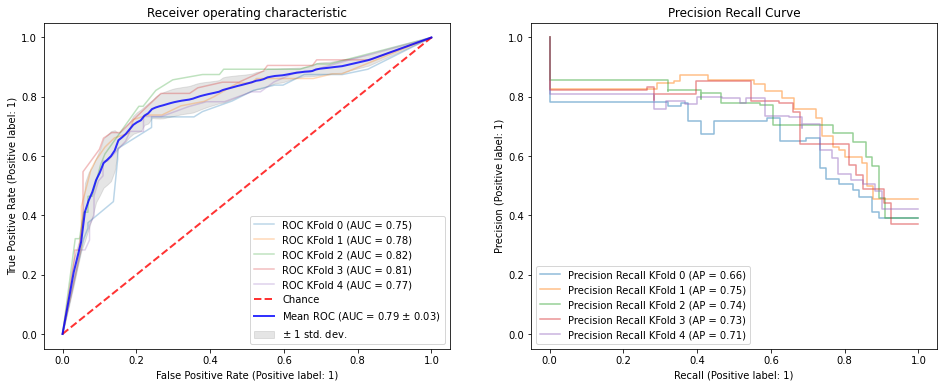

In [34]:
roc_pr_curve_display(y_true_list, y_proba_list)

### Улучшить дерево.

**How to avoid overfitting the Decision tree model**
<br>
Overfitting is one of the major problem for every model in machine learning. If model is overfitted it will poorly generalized to new samples. To avoid decision tree from overfitting we remove the branches that make use of features having low importance. This method is called as Pruning or post-pruning. This way we will reduce the complexity of tree, and hence imroves predictive accuracy by the reduction of overfitting.
<br> <br>
Pruning should reduce the size of a learning tree without reducing predictive accuracy as measured by a cross-validation set. There are 2 major Pruning techniques.
Minimum Error: The tree is pruned back to the point where the cross-validated error is a minimum.
Smallest Tree: The tree is pruned back slightly further than the minimum error. Technically the pruning creates a decision tree with cross-validation error within 1 standard error of the minimum error.
<br> <br>

**Early Stop or Pre-pruning**

<br>
An alternative method to prevent overfitting is to try and stop the tree-building process early, before it produces leaves with very small samples. This heuristic is known as early stopping but is also sometimes known as pre-pruning decision trees. <br> <br>
At each stage of splitting the tree, we check the cross-validation error. If the error does not decrease significantly enough then we stop. Early stopping may underfit by stopping too early. The current split may be of little benefit, but having made it, subsequent splits more significantly reduce the error. <br> <br>
Early stopping and pruning can be used together, separately, or not at all. Post pruning decision trees is more mathematically rigorous, finding a tree at least as good as early stopping. Early stopping is a quick fix heuristic. If used together with pruning, early stopping may save time. After all, why build a tree only to prune it back again? <br> <br>

**Adding hyperparameters**

<br>

Lets try to add hyperparameters such as:
 - max_depth – maximum depth of the tree
 - criterion – choosing criteria between Gini and Information Gain
 - min_samples_leaf – the minimum number of samples required to be at a leaf node.

In [35]:
training_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]
header = ["color", "diameter", "label"]

#### criterion: "gini" | Gini Impurity

https://victorzhou.com/blog/gini-impurity/

In [59]:
def gini_impurity(rows: list) -> float:
    """Calculates the Gini Impurity for a single branch.
    """
    counts = class_counts(rows)
    impurity = 0
    for label in counts:
        # p – probability of randomly picking an element of labeled class
        p = counts[label] / len(rows)
        impurity += p * (1 - p)
    return impurity

In [60]:
gini_impurity(training_data)

0.64

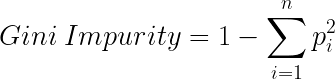

In [63]:
def gini_impurity2(rows: list) -> float:
    """Calculates the Gini Impurity with inverted probability (just as example).
    """
    counts = class_counts(rows)
    impurity = 1
    for label in counts:
        # p – probability of randomly picking an element of labeled class
        p = counts[label] / len(rows)
        impurity -= p**2
    return impurity

In [37]:
gini_impurity2(training_data)

0.6399999999999999

$$Gini_{W} = \frac {n_{L}}{n} Gini_{L} + \frac {n_{R}}{n} Gini_{R}$$

In [40]:
def weighted_impurity(left, right) -> float:
    """Weighting the impurity of each branch by how many elements it has.
    """
    # Probability on left
    p_left = len(left) / (len(left) + len(right))
    
    # Probability on right
    p_right = 1 - p_left
    
    impurity = p_left * gini_impurity(left) + p_right * gini_impurity(right)
    
    return impurity

#### criterion: "entropy" | Information Gain

https://victorzhou.com/blog/information-gain/

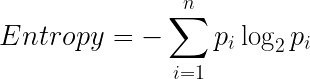

In [64]:
def entropy(rows: list) -> float:
    """Entropy can be roughly thought of as how much variance the data has.
    Entropy is zero when there are instances of only one class in the list.
    Otherwise it is positive number.
    """
    counts = class_counts(rows)
    entropy = 0
    for label in counts:
        # p – probability of randomly picking an element of labeled class
        p = counts[label] / float(len(rows))
        entropy += p * np.log2(p)
    return -entropy

In [65]:
entropy(training_data)

1.5219280948873621

In [43]:
def weighted_entropy(left, right) -> float:
    """Weighting the impurity of each branch by how many elements it has.
    """
    # Probability on left
    p_left = len(left) / (len(left) + len(right))
    
    # Probability on right
    p_right = 1 - p_left
    
    w_entropy = p_left * entropy(left) + p_right * entropy(right)
    
    return w_entropy

#### Дополненный механизм сплита

In [44]:
def find_best_split(rows: list, criterion: str, min_samples_leaf: int) -> list:
    """Finds the best question to ask by iterating over every feature / value
    and calculating the gini gain for it.
    """
    if criterion == 'gini':
        before_split = gini_impurity(rows)
    elif criterion == 'entropy':
        before_split = entropy(rows)
  
    best_gain = 0  # keep track of the best gain
    best_question = None  # keep track of the feature / value that produced it
    
    n_features = len(rows[0]) - 1  # number of columns | last feature is target (dropped)
    for col in range(n_features):  # for each feature
        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each unique value

            question = Question(col, val)  # ask what if we partition COL by VAL and OTHERS

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the dataset.
            if len(true_rows) < min_samples_leaf or len(false_rows) < min_samples_leaf:
                continue

            # Calculate the gain from this split
            if criterion == 'gini':               
                gain = before_split - weighted_impurity(true_rows, false_rows)
            elif criterion == 'entropy':
                gain = before_split - weighted_entropy(true_rows, false_rows)
                
            if gain > best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [45]:
find_best_split(training_data, criterion='gini', min_samples_leaf=2)

(0.37333333333333335, Is color == Red?)

In [46]:
find_best_split(training_data, criterion='entropy', min_samples_leaf=2)

(0.9709505944546685, Is color == Red?)

#### Дополненный механизм построения дерева

In [47]:
def build_tree(rows: list, criterion: str='gini', min_samples_leaf: int=1, max_depth: float=np.inf) -> Decision_Node:
    """Builds the tree. This is a customized version with added hyperparameters.
    """
    # Convert pd.DataFrame to array
    if type(rows) == pd.DataFrame:
        rows = rows.values
        
    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows, criterion, min_samples_leaf)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0 or max_depth == 0:
        return Leaf(rows)
    
    # check min_samples_split here 

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows, criterion, min_samples_leaf, max_depth-1)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows, criterion, min_samples_leaf, max_depth-1)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # depending on the answer.
    return Decision_Node(question, true_branch, false_branch)

### Подобрать гиперпараметры, посчитать метрики и построить кривые.

In [48]:
def custom_cross_val2(df: pd.DataFrame,
                      criterion: str='gini', min_samples_leaf: int=1, max_depth: float=np.inf,
                      target: str='Survived') -> list:
    """Calculates predictions and predict_probas based on KFold from SKlearn.
    This version have added hyperparameters.
    """
    # Separates the target feature for sake of comfort
    X = df.drop(target, axis=1).values
    y = df[target].values

    # Creates blank lists for output
    y_proba_list = []
    y_pred_list = []
    y_true_list = []

    # K-Fold from SKlearn
    kf = KFold(n_splits=5, random_state=42, shuffle=True)

    # Now for each fold (set of indices)
    for train_index, test_index in kf.split(df):

        # Fit the model
        model = build_tree(df.iloc[train_index], criterion, min_samples_leaf, max_depth-1)

        # Get the prediction
        y_pred, y_proba = predict(X[test_index], model, return_proba=True)

        # Scatter the result over the prepared lists
        y_pred_list.append(y_pred)
        y_proba_list.append(y_proba)
        y_true_list.append(y[test_index])
        
    return y_pred_list, y_proba_list, y_true_list

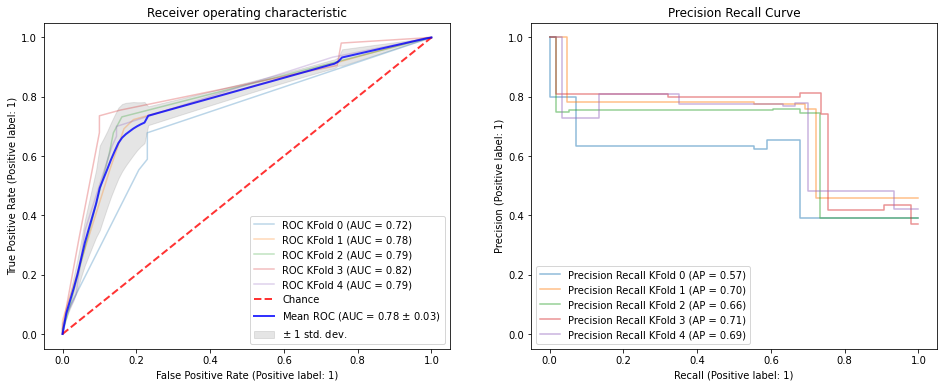

Cross-validation II:
AVG Accuracy score: 0.7759 [std: 0.0266]
AVG ROC AUC score:  0.76439 [std: 0.0265]


In [66]:
y_pred_list, y_proba_list, y_true_list = custom_cross_val2(df, max_depth=4)
roc_pr_curve_display(y_true_list, y_proba_list)

accuracy = []
roc_auc = []

for index in range(5):
    accuracy.append(accuracy_score(y_true_list[index], y_pred_list[index]))
    roc_auc.append(roc_auc_score(y_true_list[index], y_pred_list[index]))
    
print('Cross-validation II:')
print('AVG Accuracy score: {:.5} [std: {:.3}]'.format(np.mean(accuracy), np.std(accuracy)))
print('AVG ROC AUC score:  {:.5} [std: {:.3}]'.format(np.mean(roc_auc), np.std(roc_auc)))

### Подобрать два threshold’а так, чтоб если уж алгоритм сказал, что пассажир погибнет, то он наверняка (не более 5% ошибок) погибнет, а если выживет, то выживет. Всё что между – неопределённо. Построить confusion matrix для отложенной выборки.

In [50]:
def cf_matrix(true, prediction, ax, title):
    """Custom interface for the Confusion Matrix output.
    """
    cf_matrix = confusion_matrix(true, prediction)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]

    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, fmt='', cmap='Blues', ax=ax,
                annot=labels, annot_kws={'size': 16})

    ax.set_title(title)

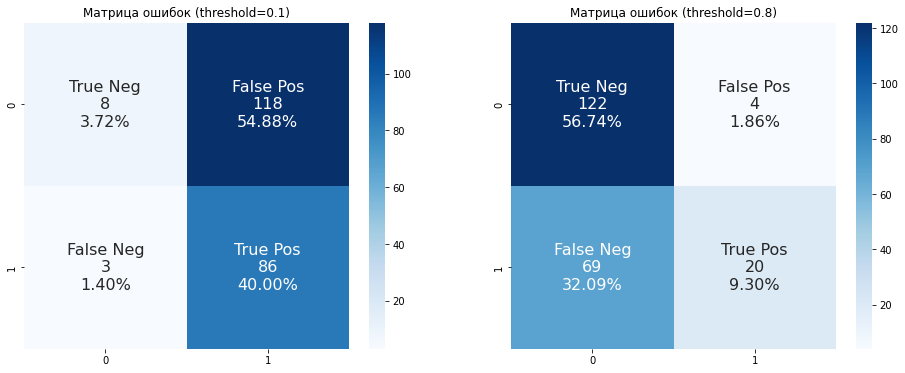

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df, df[target], test_size=0.3, random_state=42)

X_test = X_test.drop(target, axis=1)
y_test = y_test.values

# Fit
my_tree = build_tree(X_train, max_depth=4)


# Confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
cf_matrix(y_test, predict(X_test, my_tree, threshold=0.1), ax=ax1, title='Матрица ошибок (threshold=0.1)')
cf_matrix(y_test, predict(X_test, my_tree, threshold=0.8), ax=ax2, title='Матрица ошибок (threshold=0.8)')

Вывод:
* При нижнем пороге в 0.1 модель будет ошибаться с классом 0 не чаще 5% случаев;
* При верхнем пороге в 0.8 модель будет ошибаться с классом 1 не чаще 5% случаев;
* Большая часть объектов попадает в серую зону при таких порогах.

### Применить дерево к большему количеству признаков из датасета Титаник, добиться улучшения точности. Продемонстрировать скор на лидерборде и на кросс валидации.

**Загрузим полный набор данных.**

In [71]:
train_df = pd.read_csv(PATH+'train.csv')
test_df = pd.read_csv(PATH+'test.csv')

print(f"Train: {train_df.shape[0]} passenger, and {train_df.shape[1]} features")
print(f"Test: {test_df.shape[0]} passengers, and {test_df.shape[1]} features")

Train: 891 passenger, and 12 features
Test: 418 passengers, and 11 features


**Проверим данные на наличие пропусков.**

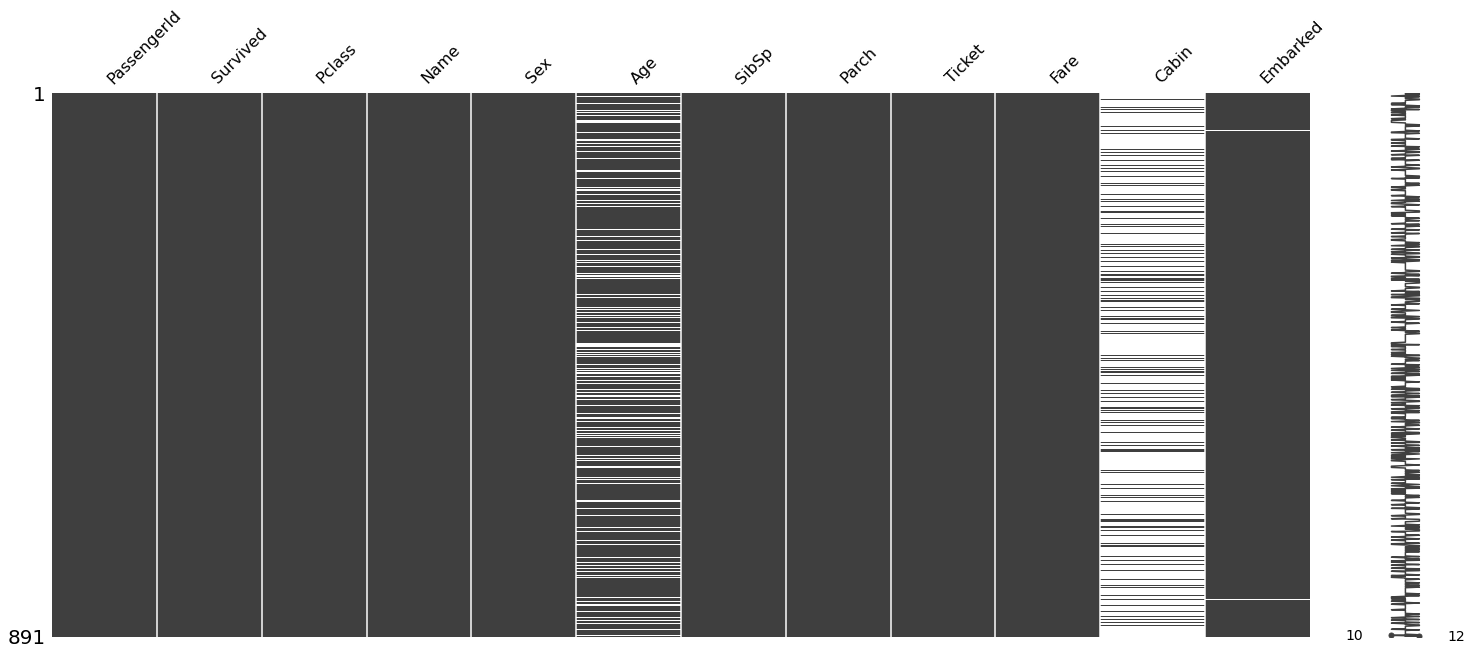

In [72]:
msno.matrix(train_df);

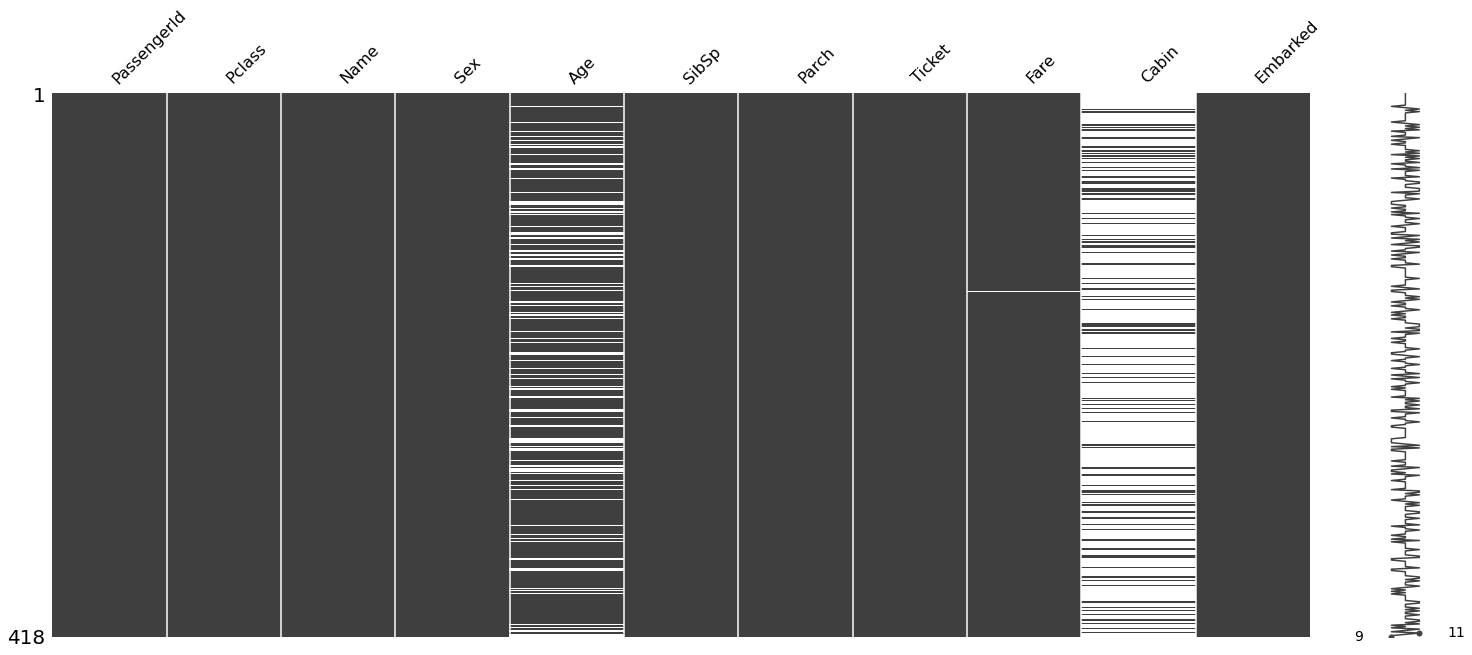

In [73]:
msno.matrix(test_df);

**Обработаем пропуски**

In [74]:
# Impute missing value in data for column 'Age' with its primary mode
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].dropna().mode()[0])
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].dropna().mode()[0])

# Impute missing value in train data for column 'Embarked' with its primary mode
train_df['Embarked'].fillna(train_df['Embarked'].dropna().mode()[0], inplace=True)

# Impute missing value in test data for column 'Fare' with its median
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

**Обучим модель**

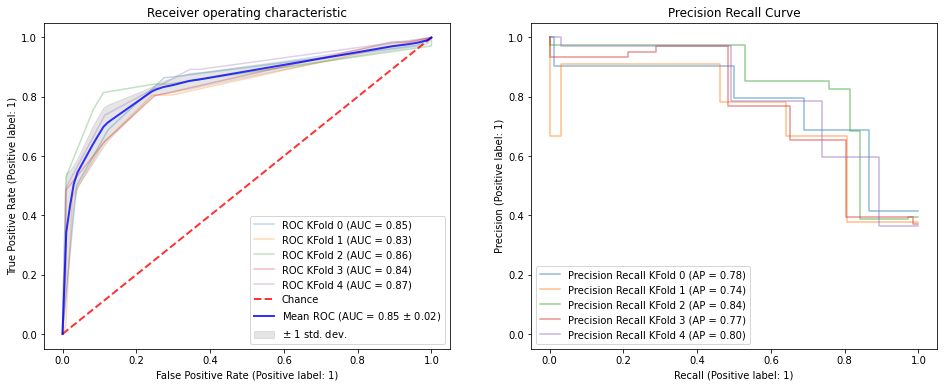

Cross-validation III:
AVG Accuracy score: 0.81708 [std: 0.0249]
AVG ROC AUC score:  0.79611 [std: 0.0321]


In [75]:
col_order = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']

y_pred_list, y_proba_list, y_true_list = custom_cross_val2(train_df[col_order], max_depth=4)

accuracy = []
roc_auc = []

for index in range(5):
    accuracy.append(accuracy_score(y_true_list[index], y_pred_list[index]))
    roc_auc.append(roc_auc_score(y_true_list[index], y_pred_list[index]))

roc_pr_curve_display(y_true_list, y_proba_list)

print('Cross-validation III:')
print('AVG Accuracy score: {:.5} [std: {:.3}]'.format(np.mean(accuracy), np.std(accuracy)))
print('AVG ROC AUC score:  {:.5} [std: {:.3}]'.format(np.mean(roc_auc), np.std(roc_auc)))

1. Первый проход | признаки: 'Sex', 'Age'
```python
Cross-validation I:
AVG Accuracy score: 0.76889 [std: 0.0104]
AVG ROC AUC score:  0.74734 [std: 0.0122]
```

2. Второй проход | добавлен гиперпараметр max_depth
```python
Cross-validation II:
AVG Accuracy score: 0.7759 [std: 0.0266]
AVG ROC AUC score:  0.76439 [std: 0.0265]
```

3. Третий проход | признаки: 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'
```python
Cross-validation III:
AVG Accuracy score: 0.81708 [std: 0.0249]
AVG ROC AUC score:  0.79611 [std: 0.0321]
```

**Вывод**: качество выросло в результате увеличения числа признаков, предобработки и настройки глубины.

**Kaggle**: 0.77990 на лидерборде.

In [69]:
kaggle_tree = build_tree(train_df[col_order], max_depth=4)
kaggle_pred = predict(test_df[col_order[:-1]], kaggle_tree)

test_df['Survived'] = kaggle_pred
test_df.set_index('PassengerId')[['Survived']].to_csv(PATH+'submission.csv')

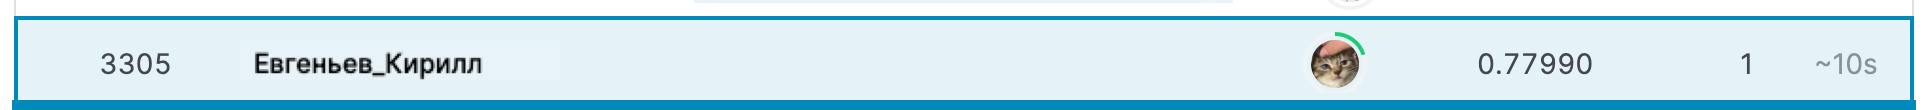